In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
root = '/content/drive/MyDrive/JunctionX/Data_preprocess'

In [3]:
import os
import cv2
import numpy as np

In [4]:
width = 256
height = 256
images = np.empty(shape=(0, height, width, 3), dtype='uint8')
for i in range(0, len(os.listdir(root))):
    image = cv2.imread(root + '/' + os.listdir(root)[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (height, width))
    images = np.append(images, [image/255], axis=0)
print(images.shape)

(29, 256, 256, 3)


In [5]:
width = int(224)
height = int(224)
dim = (width, height)
resized_images=[]
for i in range(0,images.shape[0]):
        resized = cv2.resize(images[i], dim, interpolation = cv2.INTER_AREA)
        resized_images.append(resized)

print(len(resized_images))

29


In [6]:
from keras.applications import VGG16
from keras import Input, Model
from keras.layers import Flatten


model = VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

553467904/553467096 [==============================] - 3s 0us/step


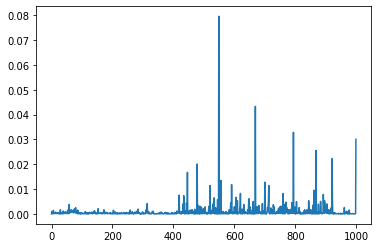

In [8]:
pred = model.predict(np.array([resized_images[0]]))[0]
import matplotlib.pyplot as plt
plt.plot(pred)
plt.show()

In [9]:

convoluted_array = np.empty(shape=(0, 224*224*3))
for j in range(0, len(resized_images)):
    # pred = model.predict(np.array([resized_images[j]]))
    pred = resized_images[j].flatten().reshape(1,224*224*3)

    convoluted_array = np.append(convoluted_array, pred, axis=0)
print(convoluted_array.shape)

(29, 150528)


In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.99)
pca.fit(convoluted_array)
print(pca.n_components_)

21


In [11]:
decomposed_array = pca.transform(convoluted_array)
print(decomposed_array.shape)

(29, 21)


In [12]:
max_length = 29
n_features = pca.n_components_
output = 224*224*3
X = np.empty(shape=(0, max_length, output))
y = np.empty(shape=(0, output))
c = 0
def pad_seq(im_seq, max_len):
    empty = np.zeros(im_seq[0].shape)
    result = []
    ep = [empty] * (max_len - len(im_seq))
    for i in range(0, len(ep)):
        result.append(ep[i])
    for i in range(0, len(im_seq)):
        result.append(im_seq[i])
    return np.array(result, dtype='float64')


for i in range(0, len(decomposed_array) - 1):
    inp = convoluted_array[0:c+1]
    # inp = decomposed_array[0:c + 1]
    inp = pad_seq(inp, max_length)
    target = resized_images[c+1].reshape(1,224*224*3)
    X = np.append(X, [inp], axis=0)
    y = np.append(y, target, axis=0)
    c += 1
print(X.shape)
print(y.shape)

(28, 29, 150528)
(28, 150528)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.3050 - val_loss: 0.2955
Epoch 2/100
1/1 [==============================] - 0s 274ms/step - loss: 0.2956 - val_loss: 0.2830
Epoch 3/100
1/1 [==============================] - 0s 282ms/step - loss: 0.2833 - val_loss: 0.2636
Epoch 4/100
1/1 [==============================] - 0s 280ms/step - loss: 0.2665 - val_loss: 0.2401
Epoch 5/100
1/1 [==============================] - 0s 277ms/step - loss: 0.2449 - val_loss: 0.2146
Epoch 6/100
1/1 [==============================] - 0s 283ms/step - loss: 0.2152 - val_loss: 0.1885
Epoch 7/100
1/1 [==============================] - 0s 296ms/step - loss: 0.1856 - val_loss: 0.1628
Epoch 8/100
1/1 [==============================] - 0s 276ms/step - loss: 0.1695 - val_loss: 0.1386
Epoch 9/100
1/1 [==============================] - 0s 293ms/step - loss: 0.1376 - val_loss: 0.1164
Epoch 10/100
1/1 [==============================] - 0s 282ms/step - loss: 0.1242 - val_loss: 0.0967
Epoch 11/100

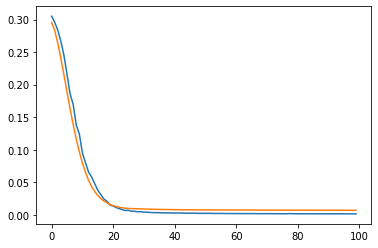

In [35]:
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import InputLayer


modelLSTM = Sequential()
modelLSTM.add(InputLayer(input_shape=(max_length, output)))
modelLSTM.add(LSTM(units=16, dropout=0.1,))
modelLSTM.add(Dense(256, activation='tanh'))
modelLSTM.add(Dropout(0.5))
modelLSTM.add(Dense(output, activation='tanh'))
modelLSTM.compile(loss='msle', optimizer='adam')
h = modelLSTM.fit(X, y, validation_split=0.7, epochs=100, verbose=1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.show()

(224, 224, 3)


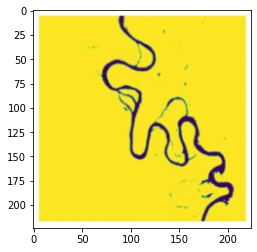

In [14]:
test_image = resized_images[16]
plt.imshow(test_image)
print(test_image.shape)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 29, 150528)


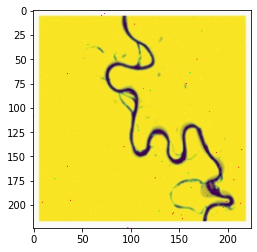

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 29, 150528)


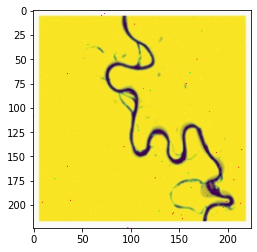

<Figure size 432x288 with 0 Axes>

In [29]:
from sklearn.metrics import mean_squared_error
%matplotlib inline
results = [resized_images[0]]
for i in range(2):
  predn = results[-1].reshape(1,224*224*3)
  predn = np.array([pad_seq(predn, max_length)])
  print(predn.shape)
  predn = modelLSTM.predict(predn)


  image = predn.reshape(224,224,3)
  results.append(image)
  plt.imshow(image)
  plt.savefig('/content/drive/MyDrive/JunctionX/Predictions/{}.png'.format(i))
  plt.show()
  plt.clf()
  plt.show()

In [ ]:
results[0] == resized_images[1]

In [42]:
results[0]

(224, 224, 3)

(1, 29, 150528)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


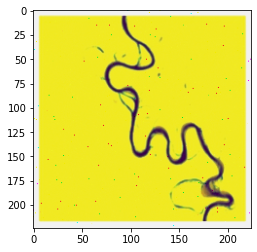

<Figure size 432x288 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 29, 150528)


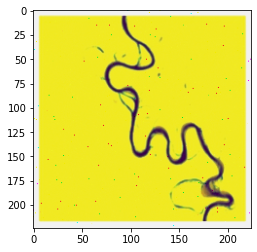

<Figure size 432x288 with 0 Axes>

In [44]:
from sklearn.metrics import mean_squared_error
%matplotlib inline
results2 = [resized_images[-2]]
for i in range(2):
  predn = results[-1].reshape(1,224*224*3)
  predn = np.array([pad_seq(predn, max_length)])
  print(predn.shape)
  predn = modelLSTM.predict(predn)
  image = predn.reshape(224,224,3)
  results2.append(image)
  plt.imshow(image)
  plt.savefig('/content/drive/MyDrive/JunctionX/Predictions/{}_new.png'.format(i))
  plt.show()
  plt.clf()
  plt.show()

In [43]:
# Accuracy:
np.sum(results2[0] == resized_images[-1])/(224*224*3)*100

70.31715029761905

In [47]:
np.sum(results[0] == results2[0])/(224*224*3)*100

58.73126594387755

Difference is very small to notice for different inputs! 

Unfortunately, we don't have enough data for training...

However, next steps might include incorporating monthly images and using Sequencial GANs.